### Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import missingno as msno
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,precision_score,recall_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import sklearn.metrics 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
# model explainers
import lime
from lime.lime_tabular import LimeTabularExplainer

# command for work offline
plotly.offline.init_notebook_mode(connected=True)
warnings.simplefilter('ignore')

In [2]:
#sns.set(style="ticks", context="talk")
plt.style.use("ggplot")

### Import Diabetes_data.csv

In [3]:
dia_df = pd.read_csv('diabetic_data.csv')

### All the missing values are filled '?' , replacing them with Nan so that its easy to impute later

In [4]:
dia_df.replace('?',np.nan,inplace=True)

### View the missing values in the graph

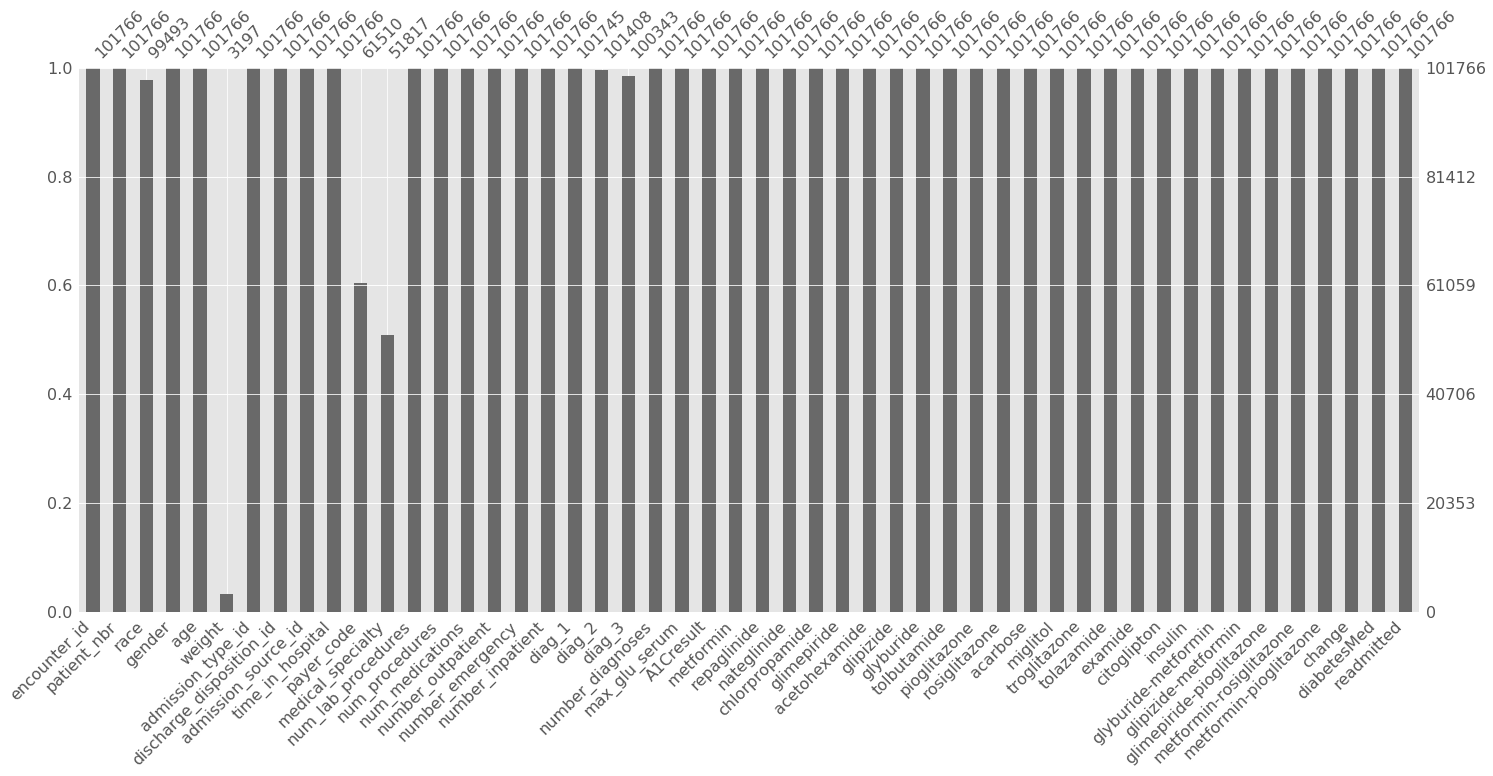

In [5]:
plt.figure(figsize=(10,8))
msno.bar(dia_df)

In [6]:
dia_df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


### Data Cleanup
    ==> Looking at the graph above we can see that the features 'weight' ,' medical_specialty','payer_code' have         lots of missing data, hence delete those rows . 
    ==> By closely observing the data there are lot of ID's such as patient_nbr, encounter_id,admission_type_id,discharge_disposition_id,admission_source_id which are not necessary for further analysis.
    ==>Removing the rows with gender as Unknown/Invalid
    ==>Dropping columns that have Nan values
    

In [7]:
dia_df.drop(['admission_type_id','discharge_disposition_id','encounter_id','admission_source_id','patient_nbr'],axis=1,inplace=True)
dia_df.drop(['weight','medical_specialty','payer_code'],axis =1 ,inplace = True)
dia_df=dia_df[dia_df['gender']!='Unknown/Invalid']
dia_df.dropna(inplace=True)



### Lets look at few features that are factors and get more insights .
    Looking at age,gender,race

In [8]:
print("Gender",dia_df.gender.unique(),"\n")
print('Age range',dia_df.age.unique(),"\n")
print('Race',dia_df.race.unique(),"\n")

Gender ['Female' 'Male'] 

Age range ['[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)'
 '[80-90)' '[90-100)' '[0-10)'] 

Race ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic'] 



https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9

#### The datatype of these diag columns  are 'object', so lets clean this up and convert it to float
    ==> Extract the characters V and E from the columns 
    

In [9]:
diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    dia_df[col] = dia_df[col].str.replace('E','0')
    dia_df[col] = dia_df[col].str.replace('V','0')
dia_df[diag_cols] = dia_df[diag_cols].astype(float)

In [10]:
dia_df['age'] = dia_df['age'].str[1:].str.split('-',expand = True)[1]
dia_df['age'] = dia_df['age'].str.split(')',expand = True)[0]
dia_df['age'] = dia_df['age'].astype(int)

In [11]:

dia_df['max_glu_serum'] = dia_df['max_glu_serum'].map({'None':0,'Norm':100,'>200':200,'>300':300})
dia_df['A1Cresult'] = dia_df['A1Cresult'].map({'None':0,'Norm':5,'>7':7,'>8':8})
dia_df['change'] = dia_df['change'].map({'No':0,'Ch':1})
dia_df['diabetesMed'] = dia_df['diabetesMed'].map({'No':0,'Yes':1})


In [12]:

feature_cols = ['metformin','repaglinide','nateglinide','chlorpropamide',
 'glimepiride','acetohexamide','glipizide','glyburide',
 'tolbutamide','pioglitazone','rosiglitazone','acarbose',
 'miglitol','troglitazone','tolazamide','examide',
 'citoglipton','insulin','glyburide-metformin','glipizide-metformin',
 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']
for col in feature_cols:
    dia_df[col] = dia_df[col].map({'Up':1,
                    'Down':-1,
                    'Steady':0,
                    'No':-2
                   })

dia_df['readmitted'] = dia_df['readmitted'].map({'NO':0,'<30':1,'>30':2})


### Lets do some EXPLORATORY DATA ANALYSIS

### In this graph, we have looked at Age against number of Lab Procedures , and looking at the readmission count, here 0 is NO Readmission, 1 is less than 30 Readmissions, 2 is greater than 30 Readmissions


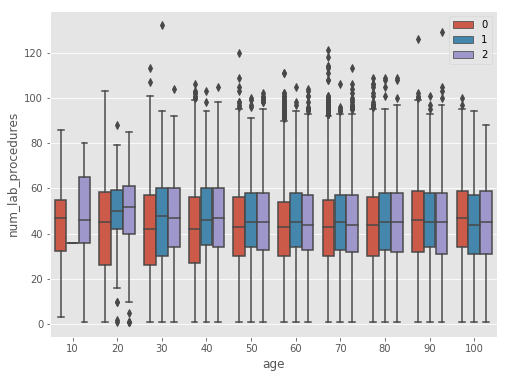

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(dia_df.age,dia_df.num_lab_procedures,hue = dia_df.readmitted)
plt.legend(loc = 0)

##### Below graph shows the emergency cases according to Races, and we can observe that Asians are less in number compared to Hispanic(Latinos),Caucasian(Russia,Georgia,Armenia,Azeribaijan) and African American

Text(0.5,1,'Race V/S Number of Emergencies')

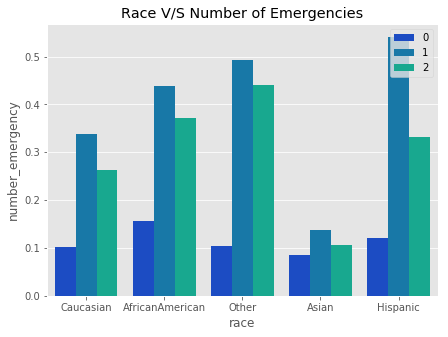

In [14]:
plt.figure(figsize=(7,5))
sns.barplot(dia_df.race,dia_df.number_emergency,hue = dia_df.readmitted,palette='winter',ci = None)
plt.legend(loc = 1)
plt.title("Race V/S Number of Emergencies")

##### Number of medications V/s Race 

Text(0.5,1,'Race V/S Number of Medications')

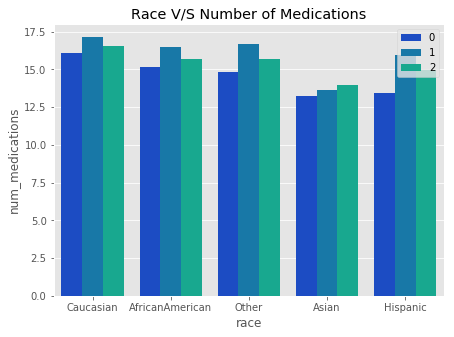

In [15]:
plt.figure(figsize=(7,5))
sns.barplot(dia_df.race,dia_df.num_medications,hue = dia_df.readmitted,palette='winter',ci = None)
plt.legend(loc = 1)
plt.title("Race V/S Number of Medications")

##### Detailed Grid of Readmissions with a scatter plot of number of procedures with number of emergencies, distinguishing by Gender

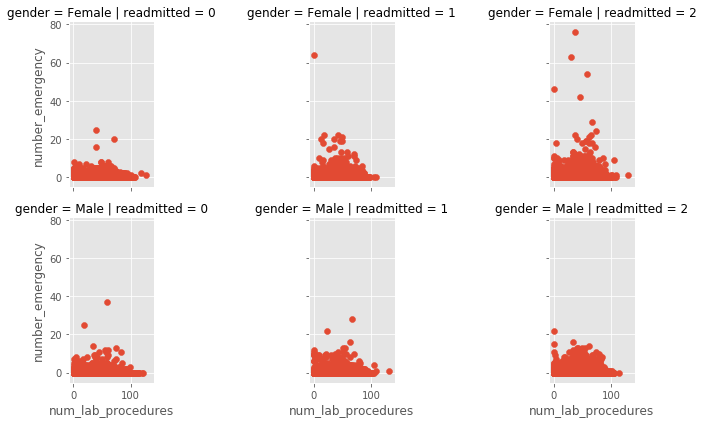

In [16]:
g = sns.FacetGrid(dia_df, row="gender",  col="readmitted")
g = g.map(plt.scatter, "num_lab_procedures", "number_emergency")

plt.tight_layout()
plt.subplots_adjust(wspace = 1.8)

##### From the above graph it clearly shows that females have higher cases of Readmissions > 30(readmitted = 2 in our case)

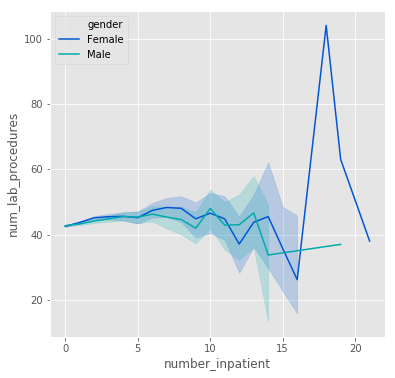

In [17]:
plt.figure(figsize=(6,6))
sns.lineplot(dia_df.number_inpatient,dia_df.num_lab_procedures,hue= dia_df.gender,palette='winter',sort= True)


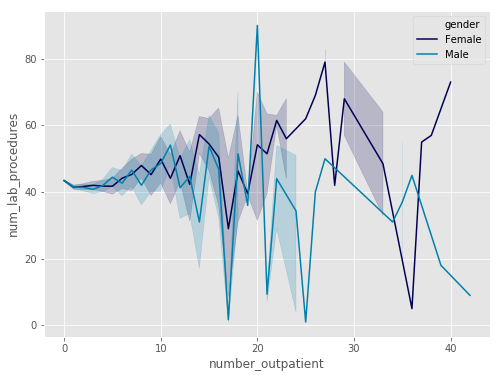

In [18]:
plt.figure(figsize=(8,6))
sns.lineplot(dia_df.number_outpatient,dia_df.num_lab_procedures,palette='ocean',hue = dia_df.gender,ci = 95,sort = True,
            estimator = 'mean')


##### Graph below shows number of Lab Procedures for inpatients 

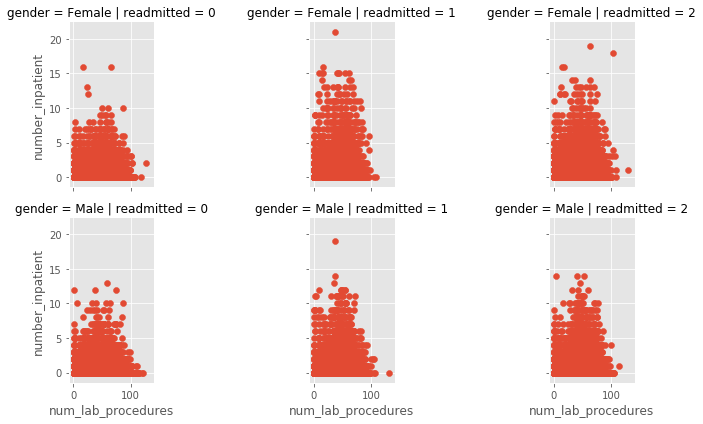

In [19]:
g = sns.FacetGrid(dia_df, row="gender",  col="readmitted")
g = g.map(plt.scatter, "num_lab_procedures", "number_inpatient")
plt.tight_layout()
plt.subplots_adjust(wspace = 1.8)

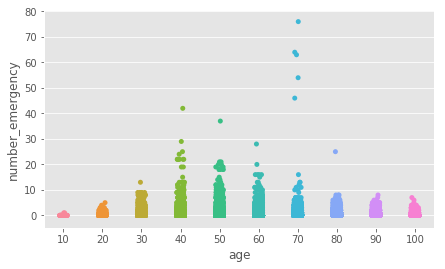

In [20]:
plt.figure(figsize=(7,4))
sns.stripplot(dia_df.age,dia_df.number_emergency,dodge=True)

##### In the above graph Emergency cases are higher in the age group 60,70 alarmingly at 30 years too!


Text(0.5,1,'Age V/s Number of Outpatients')

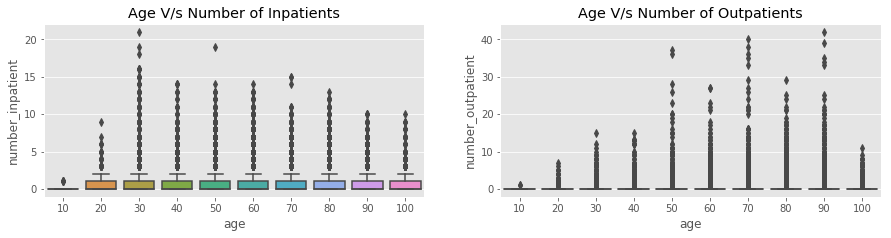

In [21]:
plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
sns.boxplot(dia_df.age,dia_df.number_inpatient)
plt.title("Age V/s Number of Inpatients")
plt.subplot(2,2,2)
sns.boxplot(dia_df.age,dia_df.number_outpatient)
plt.title("Age V/s Number of Outpatients")

Text(0.5,1,'Age V/s Number of Outpatients')

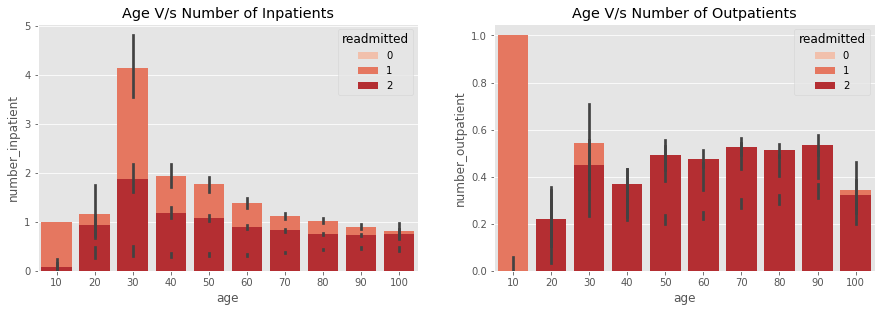

In [22]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.barplot(dia_df.age,dia_df.number_inpatient,hue=dia_df.readmitted,palette='Reds',dodge=False)
plt.title("Age V/s Number of Inpatients")
plt.subplot(2,2,2)
sns.barplot(dia_df.age,dia_df.number_outpatient,hue=dia_df.readmitted,palette='Reds',dodge=False)
plt.title("Age V/s Number of Outpatients")

##### We see that there are more inpatients in the age group of 20 - 30 years as compared to number of out patients

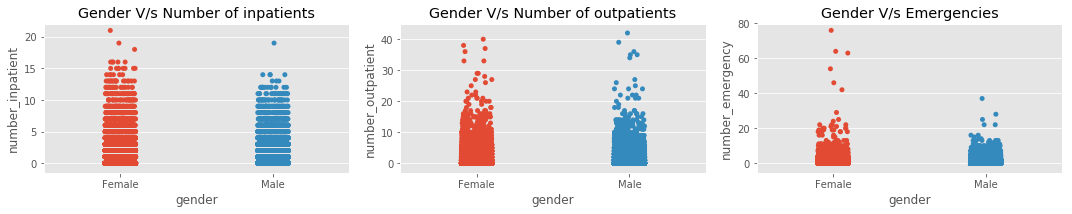

In [23]:
plt.figure(figsize=(15,8))
plt.subplot(3,3,1)
sns.stripplot(dia_df.gender,dia_df.number_inpatient)
plt.title("Gender V/s Number of inpatients")
plt.subplot(3,3,2)
sns.stripplot(dia_df.gender,dia_df.number_outpatient)
plt.title("Gender V/s Number of outpatients")
plt.subplot(3,3,3)
sns.stripplot(dia_df.gender,dia_df.number_emergency)
plt.title("Gender V/s Emergencies")
plt.tight_layout()

In [24]:
### Lets see how many patients were readmitted . 

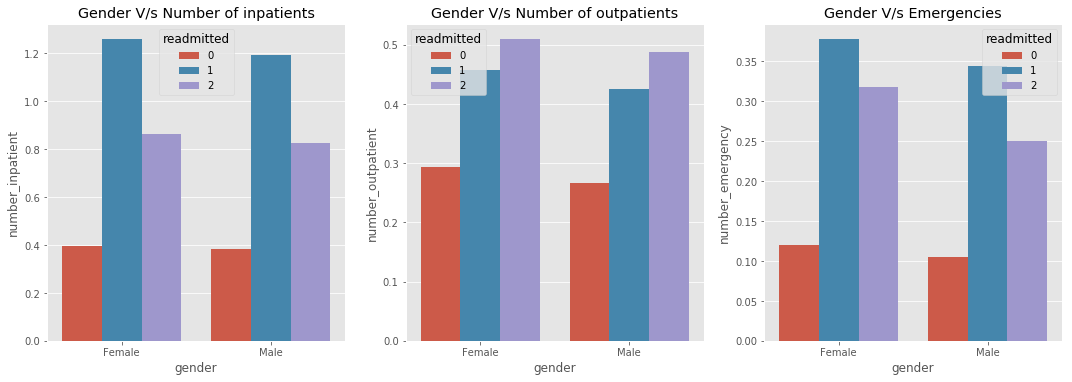

In [25]:
plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
sns.barplot(dia_df.gender,dia_df.number_inpatient,hue=dia_df.readmitted,ci = None)
plt.title("Gender V/s Number of inpatients")
plt.subplot(3,3,2)
sns.barplot(dia_df.gender,dia_df.number_outpatient,hue =dia_df.readmitted,ci = None)
plt.title("Gender V/s Number of outpatients")
plt.subplot(3,3,3)
sns.barplot(dia_df.gender,dia_df.number_emergency,hue= dia_df.readmitted,ci =None)
plt.title("Gender V/s Emergencies")
plt.tight_layout()

In [26]:
dia_df.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,20,3,59,0,18,0,0,0,...,-2,1,-2,-2,-2,-2,-2,1,1,2
2,AfricanAmerican,Female,30,2,11,5,13,2,0,1,...,-2,-2,-2,-2,-2,-2,-2,0,1,0
3,Caucasian,Male,40,2,44,1,16,0,0,0,...,-2,1,-2,-2,-2,-2,-2,1,1,0
4,Caucasian,Male,50,1,51,0,8,0,0,0,...,-2,0,-2,-2,-2,-2,-2,1,1,0
5,Caucasian,Male,60,3,31,6,16,0,0,0,...,-2,0,-2,-2,-2,-2,-2,0,1,2


### Above graph shows that females are more prone to Emergencies and more likely to get admitted to hospital.So lets  explore more

### Shockingly Females between the ages 30 - 40 have higher risk of diabetes and with maximum cases of readmission

In [27]:
female_dia = dia_df[dia_df['gender'] == 'Female']

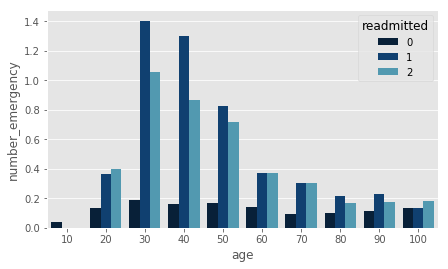

In [28]:
plt.figure(figsize=(7,4))
sns.barplot("age", "number_emergency",data = female_dia,hue='readmitted',palette='ocean',ci = None)

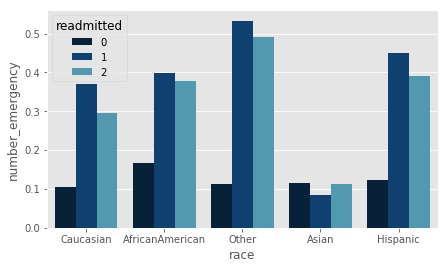

In [29]:
plt.figure(figsize=(7,4))
sns.barplot(dia_df.race, "number_emergency",data = female_dia,hue='readmitted',palette='ocean',ci = None)

### From the above graph , the diabetes prevalence in females is more frequent in AfricanAmerican and Hispanic Races

### MODELS

In [30]:
dia_df.race = pd.get_dummies(dia_df.race)
dia_df.gender = pd.get_dummies(dia_df.gender)

condition = dia_df['readmitted']!=0
dia_df['readmitted'] = np.where(condition,1,0)

In [31]:
# PCA in 2 Dimensions
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
print(pca)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


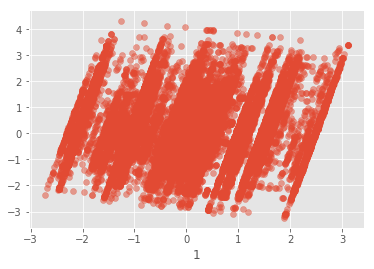

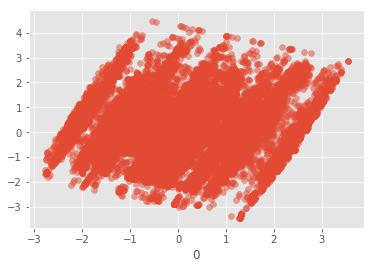

In [32]:
readmit = dia_df.readmitted.unique()
for i,class_feature in enumerate(readmit):
        class_feature_df = dia_df[dia_df['readmitted'] == class_feature]
        pca = PCA(n_components=2, whiten=True)
        X_proj = pca.fit_transform(class_feature_df.drop(['readmitted','gender','race'],axis = 1))       
        plt.scatter(X_proj[:,0], X_proj[:,1],alpha= 0.5)
        plt.xlabel(class_feature)
        plt.show()

In [33]:
# Let's run PCA with 2 components so as to plot the data in 2D
pca_digits = PCA(3)
X_proj = pca_digits.fit_transform(dia_df)
print(np.sum(pca_digits.explained_variance_ratio_))

0.9784076430967703


In [34]:
X_train,X_test,y_train,y_test = train_test_split(dia_df.drop('readmitted',axis=1),
                                                 dia_df['readmitted'],
                                                 test_size=0.30,
                                                 random_state=2)
X_train.shape,X_test.shape

((68636, 41), (29416, 41))

In [35]:
y = dia_df['readmitted']
X = dia_df.drop(['readmitted'],axis=1)

In [36]:
model = LogisticRegression(solver='liblinear',random_state=0)

In [37]:
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [38]:
print(f1_score(y_test,pred))
print(accuracy_score(y_test,pred))
print( roc_auc_score(y_test,pred))

0.4946362044975088
0.6172491161272776
0.6029161142886882


##### AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. 

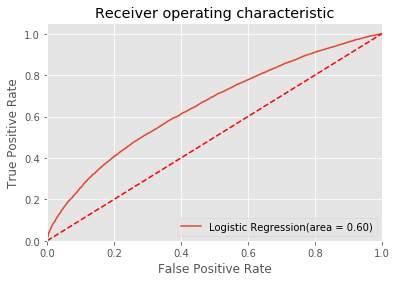

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc_logitscore = roc_auc_score(y_test, model.predict(X_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label='Logistic Regression(area = %0.2f)' % roc_auc_logitscore)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

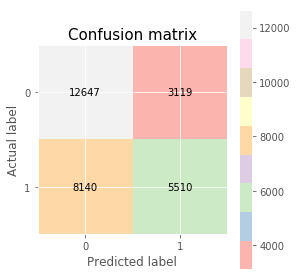

In [40]:
conf_mat = confusion_matrix(y_test,pred)
plt.figure(figsize=(4,4))
plt.imshow(conf_mat, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0", "1"])
plt.yticks(tick_marks, ["0", "1"])
plt.tight_layout()
plt.ylabel('Actual label' )
plt.xlabel('Predicted label')
wd, ht = conf_mat.shape
for x in range(wd):
    for y in range(ht):
        plt.annotate(str(conf_mat[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

https://www.kaggle.com/aldrinl/interpretable-ml-for-diabetes-patient-readmission

In [41]:
#LIME explainer
explainer = LimeTabularExplainer(X_train.values,mode='classification',
                                 feature_names=X_train.columns,class_names=['Readmitted','Not Readmitted'])

In [42]:
exp = explainer.explain_instance(X_test.head(1).values[0],
                                 model.predict_proba,
                                 num_features=X_train.shape[1])
exp.show_in_notebook(show_table=True, show_all=True)

### Running a Grid Search CV for Lasso and Ridge 

##### Running Lasso first with different alpha values

In [43]:
C_params = [0.1,0.01,0.001,0.0001]
param_grid = {'penalty':['l1'],'C':C_params}

clf = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=10)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 out of  20 | elapsed:   60.0s remaining:  1.5min
[Parallel(n_jobs=10)]: Done  15 out of  20 | elapsed:  1.2min remaining:   23.3s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'penalty': ['l1'], 'C': [0.1, 0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [44]:
clf_pred = clf.predict(X_test)

print(f1_score(y_test,clf_pred))
print(accuracy_score(y_test,clf_pred))
print( roc_auc_score(y_test,clf_pred))

0.49119002439685555
0.6171471308131629
0.602457172410236


### Clearly the columns mentioned are not significant

###### A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression.Here, the columns
    number_inpatient            
    acarbose                    
    diabetesMed                
    number_emergency            
    glyburide-metformin         
    number_outpatient           
    number_diagnoses            

In [45]:
lr = clf.best_estimator_
print(lr)
feat_imp = pd.Series(index=X_train.columns, data=lr.coef_[0])
feat_imp.sort_values(ascending=False)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


number_inpatient            0.356312
acarbose                    0.243845
diabetesMed                 0.198512
number_emergency            0.189997
glyburide-metformin         0.085890
number_outpatient           0.076668
number_diagnoses            0.071110
repaglinide                 0.052587
glipizide                   0.049705
nateglinide                 0.047307
pioglitazone                0.043562
rosiglitazone               0.032543
glimepiride                 0.025607
miglitol                    0.021121
gender                      0.019942
glipizide-metformin         0.013055
glyburide                   0.011188
chlorpropamide              0.009688
time_in_hospital            0.009246
num_medications             0.002095
num_lab_procedures          0.001276
age                         0.001067
max_glu_serum               0.000383
diag_3                      0.000008
tolazamide                  0.000000
metformin-pioglitazone      0.000000
metformin-rosiglitazone     0.000000
g

#### Ridge Regression with alpha 0.001

In [46]:
lr2 = LogisticRegression(C=0.001, penalty='l2')
lr2.fit(X_train, y_train)
feat_imp = pd.Series(index=X_train.columns, data=lr2.coef_[0])
feat_imp[feat_imp!=0].sort_values(ascending=False)

number_inpatient            0.340993
number_emergency            0.179818
diabetesMed                 0.179786
number_outpatient           0.078755
number_diagnoses            0.074797
acarbose                    0.066770
glyburide-metformin         0.048732
glipizide                   0.046451
change                      0.044190
repaglinide                 0.042961
gender                      0.038624
pioglitazone                0.038245
nateglinide                 0.037965
miglitol                    0.032969
chlorpropamide              0.032271
rosiglitazone               0.029913
glipizide-metformin         0.028827
acetohexamide               0.028432
glimepiride-pioglitazone    0.028312
troglitazone                0.027694
examide                     0.027580
citoglipton                 0.027580
metformin-pioglitazone      0.027580
metformin-rosiglitazone     0.027580
tolazamide                  0.026621
tolbutamide                 0.024837
glimepiride                 0.024711
g